<a href="https://colab.research.google.com/github/SRiazRaza/Vision-and-cognitive-systems/blob/main/preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Resources and credit:
- SSDD data download: https://github.com/TianwenZhang0825/LS-SSDD-v1.0-OPEN
- Convering xml to csv: https://github.com/asetkn/Tutorial-Image-and-Multiple-Bounding-Boxes-Augmentation-for-Deep-Learning-in-4-Steps/blob/master/Tutorial-Image-and-Multiple-Bounding-Boxes-Augmentation-for-Deep-Learning-in-4-Steps.ipynb
- Detectron2 docs: https://detectron2.readthedocs.io/en/latest/index.html

#Preprocessing

## Imports

In [ ]:
import imgaug as ia
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage
from imgaug import augmenters as iaa
#import imageio
import imageio.v2 as imageio
import pandas as pd
import numpy as np
import re
import os
import glob
import xml.etree.ElementTree as ET
import shutil
import pickle
ia.seed(1)
%matplotlib inline
# Mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Global paths (Using SSDD default folder structure)
root = '/content/drive/MyDrive/SSDD/'
xml_path = '/content/drive/MyDrive/SSDD/Annotations_sub/'
jpg_path = '/content/drive/MyDrive/SSDD/JPEGImages_sub/'
dest = '/content/drive/MyDrive/SSDD/datasets/'
imagesets = '/content/drive/MyDrive/SSDD/ImageSets/Main/'

## Creating train, test, test_inshore, test_offshore folders
*Only done once after downloading LS-SSDD-v1.0 source data for the first time*

In [ ]:

#Create directories for datasets
os.mkdir(dest)
os.mkdir(dest + "train/")
os.mkdir(dest + "test/")
os.mkdir(dest + "test_offshore/")
os.mkdir(dest + "test_inshore/")

FileExistsError: ignored

In [ ]:
test = pd.read_csv(imagesets + 'test.txt', header = None, names = ['file'])
train = pd.read_csv(imagesets + 'train.txt', header = None, names = ['file'])
test_offshore = pd.read_csv(imagesets + 'test_offshore.txt', header = None, names = ['file'])
test_inshore = pd.read_csv(imagesets + 'test_inshore.txt', header = None, names = ['file'])

In [ ]:
# Function that moves files from JPEG to dataset folder
def copyFiles(df, orig = None, dest = None):
  i = 0
  for index, rows in df.iterrows():
    i += 1
    if i % 100 == 0:
            print (i)
    shutil.copyfile(orig + rows['file'] + '.jpg',
                    dest + rows['file'] + '.jpg')
  print("Moved " + str(i) + " files.")

In [ ]:
# ONLY MEANT TO BE EXECUTED ONCE
# Move files to correct dataset path
# 3000 for Test, 6000 for Train,
copyFiles(test, jpg_path, dest + 'test/')
copyFiles(train, jpg_path, dest + 'train/')
copyFiles(test_offshore, jpg_path, dest + 'test_offshore/')
copyFiles(test_inshore, jpg_path, dest + 'test_inshore/')

## XML to CSV - Converts XML annotations to a CSV file
*Only done once after downloading LS-SSDD-v1.0 source data for the first time*

In [ ]:
# Function that will extract data from xml for our CSV file
def xml_to_csv(path):
  """Returns a pandas dataframe containing information from xml files in path"""
  xml_list = []
  for xml_file in glob.glob(path):
      tree = ET.parse(xml_file)
      root = tree.getroot()
      for member in root.findall('object'):
          value = (root.find('filename').text,
                    int(root.find('size')[0].text),
                    int(root.find('size')[1].text),
                    member[0].text,
                    int(member[4][0].text),
                    int(member[4][1].text),
                    int(member[4][2].text),
                    int(member[4][3].text)
                    )
          xml_list.append(value)
  column_name = ['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax']
  xml_df = pd.DataFrame(xml_list, columns=column_name)
  return xml_df

In [ ]:
# ONLY MEANT TO BE EXECUTED ONCE
# apply xml_to_csv() function to convert all XML files in images/ folder into labels.csv
labels_df = xml_to_csv(xml_path + '*.xml')
#labels_df.to_csv(('labels.csv'), index=None)
print('Successfully converted xml to csv.')
labels_df.to_csv((root + 'labels.csv'), index=None)

Successfully converted xml to csv.


## Verify Results

In [ ]:
labels_df = pd.read_csv(root + 'labels.csv')
labels_df.shape

(6015, 8)

In [ ]:
# start by groupping each image bounding boxes coordinates
# separate dataframes are formed based on the filename
grouped = labels_df.groupby('filename') # used later
image_name = '01_18_12'
# we can pull each group with get_group() using the filename
group_df = grouped.get_group(image_name + '.xml')
group_df = group_df.reset_index()
group_df = group_df.drop(['index'], axis=1)
group_df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,01_18_12.xml,800,800,ship,624,1,654,23
1,01_18_12.xml,800,800,ship,598,76,609,94
2,01_18_12.xml,800,800,ship,632,63,650,92
3,01_18_12.xml,800,800,ship,735,63,747,79
4,01_18_12.xml,800,800,ship,215,180,230,194


AttributeError: ignored

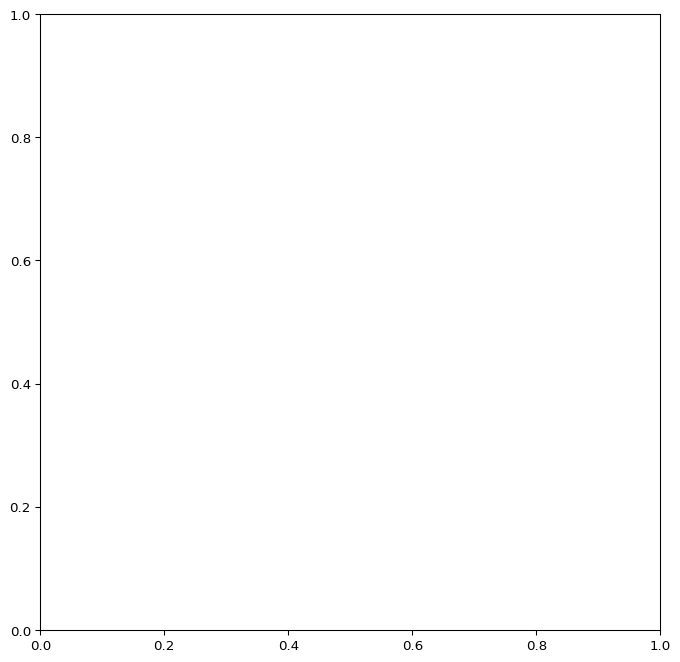

In [ ]:
# get bounding boxes coordinates from grouped data frame and write into array
bb_array = group_df.drop(['filename', 'width', 'height', 'class'], axis=1).values
image = imageio.imread(jpg_path + image_name + '.jpg')
# pass the array of bounding boxes coordinates to the imgaug library
bbs = BoundingBoxesOnImage.from_xyxy_array(bb_array, shape=image.shape)
# display the image and draw bounding boxes

ia.imshow(bbs.draw_on_image(image, size=2))

# Registering with Detectron2

## Conversion to Detectron2's Standard Dataset Dicts


According to https://detectron2.readthedocs.io/en/latest/tutorials/datasets.html#standard-dataset-dicts:

Each dict contains information about one image with the following fields:
  - file_name: the full path to the image file.
  - height, width: integer. The shape of the image.
  - image_id (str or int): a unique id that identifies this image. Required by many evaluators to identify the images, but a dataset may use it for different purposes.
  - annotations (list[dict]): Required by instance detection/segmentation or keypoint detection tasks.
  Each dict corresponds to annotations of one instance in this image, and may contain the following keys:
      - bbox (list[float], required): list of 4 numbers representing the bounding box of the instance.
      - bbox_mode (int, required): the format of bbox. It must be a member of structures.BoxMode. Currently supports: BoxMode.XYXY_ABS, BoxMode.XYWH_ABS.
      - category_id (int, required): an integer in the range [0, num_categories-1] representing the category label. The value num_categories is reserved to represent the “background” category, if applicable.

In [ ]:
# Function that converts annotations to Detectron's format
# and then saves a pickle output to path
def standardize(path, annotations, df, grouped):
  anns_id = [i.split('.')[0] for i  in annotations]
  anns_df = pd.DataFrame(anns_id, columns=['file'])
  # Attach correct image file path
  anns_df = df.merge(df,
                     on = 'file',
                     how = 'inner')
  # Give default values
  std = {i: {
        "file_name": df.loc[df['file'] == i]['type'].values[0] + i +'.jpg',
        "height": 800, # All images of the same dimension
        "width": 800, # All images of the same dimension
        "image_id": i,
        "annotations": []
        } for i in df['file'].values
      }
  # Overwrite files with correct annotations
  keys = grouped.groups.keys()
  for i in keys:
    if i.split('.')[0] in std:
      j = grouped.get_group(i)
      temp = []
      for index, row in j.iterrows():
        ann_temp = {
            'bbox' : [
                      row['xmin'],
                      row['ymin'],
                      row['xmax'],
                      row['ymax']
                      ],
            'bbox_mode': BoxMode.XYXY_ABS,
            'category_id': 0
        }
        temp.append(ann_temp)
      std[i.split('.')[0]]['annotations'] = temp
  # Cache
  f = open(path + "standardDict.pkl","wb")
  pickle.dump(list(std.values()),f)
  f.close()
  return std

In [ ]:
# Add path to datasets
test['type'] = dest + 'test/'
train['type'] = dest + 'train/'
test_offshore['type'] = dest + 'test_offshore/'
test_inshore['type'] = dest + 'test_inshore/'
# All xml annotations
anns = os.listdir(xml_path)
print(anns)

['14_19_14.xml', '14_17_27.xml', '14_13_25.xml', '14_19_15.xml', '14_17_20.xml', '14_12_26.xml', '14_15_16.xml', '14_13_20.xml', '14_12_3.xml', '14_11_28.xml', '14_13_7.xml', '14_12_13.xml', '14_13_11.xml', '14_17_26.xml', '14_18_7.xml', '14_18_6.xml', '14_17_3.xml', '14_16_10.xml', '14_15_30.xml', '14_17_18.xml', '14_15_24.xml', '14_18_3.xml', '14_16_29.xml', '14_11_21.xml', '14_17_14.xml', '14_13_8.xml', '14_18_24.xml', '14_17_5.xml', '14_14_11.xml', '14_17_19.xml', '14_14_5.xml', '14_16_15.xml', '14_19_16.xml', '14_18_5.xml', '14_15_7.xml', '14_18_13.xml', '14_13_23.xml', '14_16_6.xml', '14_13_16.xml', '14_14_27.xml', '14_15_6.xml', '14_16_5.xml', '14_11_30.xml', '14_17_12.xml', '14_15_1.xml', '14_11_24.xml', '14_12_18.xml', '14_14_17.xml', '14_12_25.xml', '14_12_5.xml', '14_18_15.xml', '14_16_9.xml', '14_11_20.xml', '14_12_11.xml', '14_16_8.xml', '14_14_1.xml', '14_17_9.xml', '14_14_30.xml', '14_15_25.xml', '14_18_11.xml', '14_15_26.xml', '14_18_9.xml', '14_14_24.xml', '14_17_17.xm

In [ ]:
# Make standardized annotations
test_std = standardize(dest + 'test/', anns, test, grouped)
train_std = standardize(dest + 'train/', anns, train, grouped)
test_o_std = standardize(dest + 'test_offshore/', anns, test_offshore, grouped)
test_i_std = standardize(dest + 'test_inshore/', anns, test_inshore, grouped)

In [ ]:


file_count = sum([len(files) for _, _, files in os.walk(xml_path)])

print(f"Number of files in the folder: {file_count}")

Number of files in the folder: 9000


In [ ]:
# Verification
print(len(test_std), len(train_std), len(anns))
assert(len(test_std) + len(train_std) == len(anns))

assert((len(test_std) == len(test_o_std) + len(test_i_std)))
train_std['01_18_12']

3000 6000 9000


{'file_name': '/content/drive/MyDrive/SSDD/datasets/train/01_18_12.jpg',
 'height': 800,
 'width': 800,
 'image_id': '01_18_12',
 'annotations': [{'bbox': [624, 1, 654, 23],
   'bbox_mode': <BoxMode.XYXY_ABS: 0>,
   'category_id': 0},
  {'bbox': [598, 76, 609, 94],
   'bbox_mode': <BoxMode.XYXY_ABS: 0>,
   'category_id': 0},
  {'bbox': [632, 63, 650, 92],
   'bbox_mode': <BoxMode.XYXY_ABS: 0>,
   'category_id': 0},
  {'bbox': [735, 63, 747, 79],
   'bbox_mode': <BoxMode.XYXY_ABS: 0>,
   'category_id': 0},
  {'bbox': [215, 180, 230, 194],
   'bbox_mode': <BoxMode.XYXY_ABS: 0>,
   'category_id': 0},
  {'bbox': [357, 227, 375, 249],
   'bbox_mode': <BoxMode.XYXY_ABS: 0>,
   'category_id': 0},
  {'bbox': [544, 237, 554, 258],
   'bbox_mode': <BoxMode.XYXY_ABS: 0>,
   'category_id': 0},
  {'bbox': [600, 160, 618, 218],
   'bbox_mode': <BoxMode.XYXY_ABS: 0>,
   'category_id': 0},
  {'bbox': [664, 246, 685, 270],
   'bbox_mode': <BoxMode.XYXY_ABS: 0>,
   'category_id': 0},
  {'bbox': [311, 35

In [ ]:
# Function that retrieves a standard dataset compatible with detectron2
def get_dict(type):
  """ Returns a list[dict] containing information about the dataset """
  import pickle
  root = '/content/drive/MyDrive/SSDD/datasets/' + type + '/'
  print(root)
  with open(root + "standardDict.pkl", "rb") as input_file:
    return pickle.load(input_file)

## Split Train into Train and Validation Sets

### Validation Set

In [ ]:
train = get_dict('train')
print(train)

/content/drive/MyDrive/SSDD/datasets/train/
[{'file_name': '/content/drive/MyDrive/SSDD/datasets/train/01_10_1.jpg', 'height': 800, 'width': 800, 'image_id': '01_10_1', 'annotations': []}, {'file_name': '/content/drive/MyDrive/SSDD/datasets/train/01_10_10.jpg', 'height': 800, 'width': 800, 'image_id': '01_10_10', 'annotations': []}, {'file_name': '/content/drive/MyDrive/SSDD/datasets/train/01_10_11.jpg', 'height': 800, 'width': 800, 'image_id': '01_10_11', 'annotations': []}, {'file_name': '/content/drive/MyDrive/SSDD/datasets/train/01_10_12.jpg', 'height': 800, 'width': 800, 'image_id': '01_10_12', 'annotations': [{'bbox': [179, 571, 197, 588], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 0}, {'bbox': [506, 314, 526, 338], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 0}]}, {'file_name': '/content/drive/MyDrive/SSDD/datasets/train/01_10_13.jpg', 'height': 800, 'width': 800, 'image_id': '01_10_13', 'annotations': []}, {'file_name': '/content/drive/MyDrive/SSDD/datasets/train

In [ ]:
k = int(len(train) * 0.15)
print(k)

900


In [ ]:
import random
random.seed(1)
total_idx = list(range(len(train)))
val_idx = random.sample(total_idx, k = k)

In [ ]:
train_idx = set(total_idx) - set(val_idx)

In [ ]:
len(train_idx)

5100

In [ ]:
assert [i for i in val_idx if i in train_idx] == []

In [ ]:
train_with_val = [train[i] for i in train_idx]
validation = [train[i] for i in val_idx]

In [ ]:
print(len(train_with_val))
print(len(validation))

5100
900


In [ ]:
#Create train_w_val and validation folder inside train, Run this code only at one
os.mkdir(dest+ 'train/train_w_val/' )
os.mkdir(dest+ 'train/validation/' )

In [ ]:

f = open(dest + 'train/train_w_val/' + "standardDict.pkl","wb")
pickle.dump(list(train_with_val),f)
f.close()

f = open(dest + 'train/validation/' + "standardDict.pkl","wb")
pickle.dump(list(validation),f)
f.close()

### Toy Dataset

In [ ]:
toy_idx = random.sample(train_idx, k = 100)
len(toy_idx)

<ipython-input-48-5c0313cf2f60>:1: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  toy_idx = random.sample(train_idx, k = 100)


100

In [ ]:
toy = [train[i] for i in toy_idx]

In [ ]:
#Create train_w_val and validation folder inside train, Run this code only at one
os.mkdir(dest+ 'train/toy/' )

In [ ]:
f = open(dest + 'train/toy/' + "standardDict.pkl","wb")
pickle.dump(list(toy),f)
f.close()

## Verify Data Loader Functionality

### Imports
*Standard from Detectron2's docs*

In [ ]:
!pip install 'git+https://github.com/facebookresearch/detectron2.git'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-o58qe0s5
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-o58qe0s5
  Resolved https://github.com/facebookresearch/detectron2.git to commit 94113be6e12db36b8c7601e13747587f19ec92fe
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 7.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 87.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 15.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for detectron2: filen

*Restart after executing this cell*

In [ ]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0
torch:  2.0 ; cuda:  cu118
detectron2: 0.6


### Verification

In [ ]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.structures import BoxMode
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [ ]:
datasets = '/content/drive/MyDrive/SSDD/datasets/'

In [ ]:
# Function that retrieves a standard dataset compatible with detectron2
def get_dict(type):
  """ Returns a list[dict] containing information about the dataset """
  import pickle
  root = '/content/drive/MyDrive/SSDD/datasets/' + type + '/'
  with open(root + "standardDict.pkl", "rb") as input_file:
    return pickle.load(input_file)

In [ ]:
from detectron2.structures import BoxMode

for d in ["train", "test", "test_offshore", "test_inshore", "train/train_w_val", "train/validation", "train/toy"]:
    DatasetCatalog.register(d, lambda d=d: get_dict(d))
    MetadataCatalog.get(d).set(thing_classes=["ship"])
train_metadata = MetadataCatalog.get('train')
train_metadata

namespace(name='train', thing_classes=['ship'])

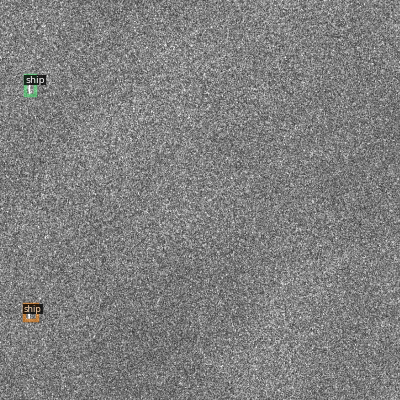

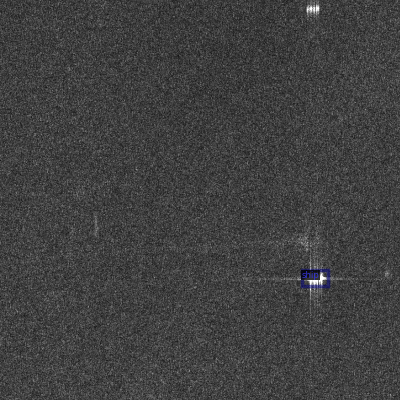

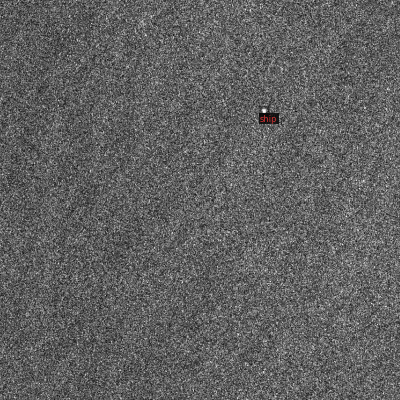

In [ ]:
dataset_dicts = get_dict("train/train_w_val")

# Filter out pics w/o annotations
dataset_dicts_anns = []
for i in dataset_dicts:
  if i['annotations'] != []:
    dataset_dicts_anns.append(i)

#random.seed(6)
for d in random.sample(dataset_dicts_anns, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=train_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    cv2_imshow(out.get_image()[:, :, ::-1])